In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

In [18]:
def contingency_table(df_review, columns=[]):
    tab = pd.crosstab(df_review['model_attr'], df_review['user_attr'], margins=True)
    if len(columns)>0:
        tab = tab[columns]
    print('contingency table')
    display(tab)
    tab = df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack()
    if len(columns)>1:
        tab = tab[columns[:-1]]
    g, p, dof, expctd = chi2_contingency(tab.values)
    print('chi2', g.round(3), 'p-value', p.round(3))
    print('')
    print('real market size - expcted market size')
    display((tab-expctd).round(2))
    

In [19]:
def chi2_test_by_year(df_review):
    chi, p, _, expctd = chi2_contingency(df_review.groupby(['model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi1, p1, _, expctd1 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year<=2014)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi2, p2, _, expctd2 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2015)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi3, p3, _, expctd3 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year==2016)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    chi4, p4, _, expctd4 = chi2_contingency(df_review.loc[
        df_review['timestamp'].apply(lambda x: x.year>=2017)].groupby([
        'model_attr', 'user_attr'])['rating'].size().unstack().values)
    df = pd.DataFrame(np.array([[chi, p, expctd.sum()],
                                [chi1, p1, expctd1.sum()],
                                [chi2, p2, expctd2.sum()],
                                [chi3, p3, expctd3.sum()],
                                [chi4, p4, expctd4.sum()],]), 
                      columns=['chi2', 'p-value', 'sum'],
                      index=['all', '<=2014', '2015', '2016', '>=2017'])
    display(df.round(3))

In [20]:
def two_way_anova(df_review, metric):
    test3 = sm.stats.anova_lm(ols(metric+' ~ model_attr*user_attr', data=df_review).fit()).values[:3,-2:]
    df = pd.DataFrame(test3, columns=['F-stat', 'p-value'], index=['product', 'user', 'product:user'])
    display(df.round(3))
    return df

In [21]:
def plot_avg_by_segment(df_review, metric, figsize, index=[], dataset='', dump=True):
    fig = plt.figure(figsize=figsize)
    group_rating = df_review.groupby(['user_attr', 'model_attr'])[metric].mean().unstack()
    group_std = 1.96*df_review.groupby(['user_attr', 'model_attr'])[metric].sem().unstack()
    if len(index)>0:
        group_rating = group_rating.loc[index]
    group_rating.index = group_rating.index.rename('user identity')
    group_rating.columns = group_rating.columns.rename('product image')
    text = []
    for ri in range(group_rating.shape[0]):
        row = []
        for ci in range(group_rating.shape[1]):
            row.append(str(group_rating.values[ri, ci].round(2))+'\n('+r'$\pm$'+str(group_std.values[ri, ci].round(2))+')')
        text.append(row)
    text = np.array(text)
    
    sns.heatmap(group_rating, annot=text, fmt='s', cmap="YlGnBu", annot_kws={"size": 13},
                cbar=False)
    if dump:
        fig.savefig('./plot/'+dataset+'_'+metric+'_heatmap.pdf', bbox_inches='tight')

# ModCloth

In [23]:
dataset = 'modcloth'

df_review = pd.read_csv('./data/df_'+dataset+'.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review['fit_score'] = 0.0
df_review['fit_score'].loc[df_review['fit'] == 'Just right'] = 1.0
df_review['fit_score'].loc[df_review['fit'].isna()] = None
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

ValueError: time data "2018-03-19 19:59:14.555000+00:00" doesn't match format "%Y-%m-%d %H:%M:%S%z", at position 2692. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

## Product Selection vs. Marketing Bias (ModCloth)
### Chi2 test of contingency table

In [24]:
contingency_table(df_review, ['Small', 'Large', 'All'])

contingency table


user_attr,Small,Large,All
model_attr,,,
Small,31800,7038,38838
Small&Large,41361,11327,52688
All,73161,18365,91526


chi2 158.739 p-value 0.0

real market size - expcted market size


user_attr,Small,Large
model_attr,,
Small,754.98,-754.98
Small&Large,-754.98,754.98


In [9]:
chi2_test_by_year(df_review)

,chi2,p-value,sum
all,158.739,0.000,91526.0
<=2014,0.532,0.466,25383.0
2015,66.722,0.000,20241.0
2016,70.816,0.000,21239.0
>=2017,29.046,0.000,24663.0


## Consumer Satisfaction vs. Marketing Bias (ModCloth)
### 2-way ANOVA on rating score

,F-stat,p-value
product,171.914,0.0
user,46.312,0.0
product:user,30.685,0.0


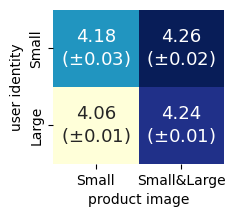

In [10]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (2.2,2), ['Small', 'Large'], dataset, dump=False)

### 2-way ANOVA on clothing fit feedback

,F-stat,p-value
product,293.111,0.000
user,402.441,0.000
product:user,0.000,0.997


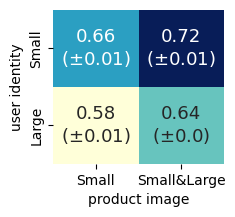

In [11]:
_ = two_way_anova(df_review, 'fit_score')
plot_avg_by_segment(df_review, 'fit_score', (2.2,2), ['Small', 'Large'], dataset, dump=False)

# Amazon Electronics

In [12]:
dataset = 'electronics'
df_review = pd.read_csv('./data/df_'+dataset+'.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])

## Product Selection vs. Marketing Bias (Electronics)
### Chi2 test of contingency table

In [13]:
contingency_table(df_review)

contingency table


user_attr,Female,Male,All
model_attr,,,
Female,34259,31587,65846
Female&Male,26478,24930,51408
Male,25963,30907,56870
All,86700,87424,174124


chi2 581.849 p-value 0.0

real market size - expcted market size


user_attr,Female,Male
model_attr,,
Female,1472.89,-1472.89
Female&Male,880.88,-880.88
Male,-2353.77,2353.77


## Consumer Satisfaction

,F-stat,p-value
product,62.581,0.000
user,3.508,0.061
product:user,0.907,0.404


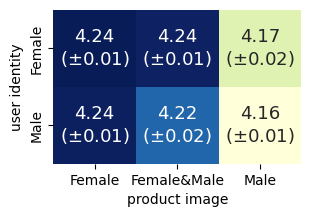

In [14]:
_ = two_way_anova(df_review, 'rating')
plot_avg_by_segment(df_review, 'rating', (3.2,2), [], dataset, dump=False)

## Testing

dataset = 'modcloth'

df_review = pd.read_csv('./data/df_'+dataset+'.csv')
#df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review['fit_score'] = 0.0
df_review['fit_score'].loc[df_review['fit'] == 'Just right'] = 1.0
df_review['fit_score'].loc[df_review['fit'].isna()] = None
#df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review

In [25]:
dataset = 'modcloth'

df1 = pd.read_csv('./data/df_'+dataset+'.csv')
df1

TypeError: __init__() got an unexpected keyword argument 'columns'

In [16]:
dataset = 'electronics'
df_review = pd.read_csv('./data/df_'+dataset+'.csv')
df_review['timestamp'] = pd.to_datetime(df_review['timestamp'])
df_review

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


In [ ]:
from jenga.corruptions import MissingValues

